In [1]:
import datetime
import time
import unittest
import pandas as pd
import pytz
import matplotlib.pyplot as plt

/tmp/ipykernel_6029/2295897713.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from tigeropen.common.consts import BarPeriod
from tigeropen.quote.quote_client import QuoteClient
from tigeropen.tiger_open_config import TigerOpenClientConfig

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [4]:
def get_client_config():
    """
    https://quant.itigerup.com/#developer 开发者信息获取
    """
    # 港股牌照需用 props_path 参数指定token路径，如 '/Users/xxx/xxx/', 如不指定则取当前路径
    client_config = TigerOpenClientConfig(props_path='tiger_openapi_config.properties')
    return client_config

In [5]:
# 调用上方定义的函数生成用户配置ClientConfig对象
client_config = get_client_config()

# 随后传入配置参数对象来初始化QuoteClient
quote_client = QuoteClient(client_config)

SYMBOL = "symbol"
TIME = "time"
CLOSE = "close"
DATE = "date"

# 需要请求的k线bar的总个数.  total number of requested bars.
BARS_TOTAL_NUMBER = 2000

# 每次请求bar的个数，系统限制每个symbol每次最多请求1200个bar.
# number of bars per request, the system limits each symbol to a maximum of 1200 bars per request.
BARS_BATCH_SIZE = 300

# 每次请求symbol的个数，系统限制每次最多请求50个symbol
# number of symbols per request, the system limits each request to a maximum of 50 symbols.
SYMBOLS_BATCH_SIZE = 50

# 每次请求的间隔时间，防止过快的请求频率触发系统限流. 单位：秒
# The interval between each request, to prevent requests too fast to trigger the system rate limit. Time unit: second
REQUEST_INTERVAL = 0.5

In [6]:
def request_bars(symbols, period, end_time, bars_batch_size):
        """
        请求k线. Request history bars.
        :param symbols: like ['AAPL', 'TSLA']
        :param period: k线周期. tigeropen.common.consts.BarPeriod. like BarPeriod.DAY
        :param end_time: end time in timestamp format. like 1645499400000
        :param bars_batch_size: 每个symbol限制请求的bar数量. bars limit size of each symbol
        :return:
        """
        symbols = list(symbols)
        result = pd.DataFrame()
        for i in range(0, len(symbols), SYMBOLS_BATCH_SIZE):
            part = symbols[i:i + SYMBOLS_BATCH_SIZE]
            quote = quote_client.get_bars(part, period=period, end_time=end_time, limit=bars_batch_size)
            #result = result.append(quote)
            result = pd.concat([result, quote])
            # to avoid rate limit
            time.sleep(REQUEST_INTERVAL)
        return result

In [7]:
# HK market
symbols = ['00700', '01024', '03690', '00992', '00762', '00998', '02020', '01109', '00981', '03988', '01398']
timezone = 'Asia/Shanghai'

end = int(datetime.datetime.today().timestamp() * 1000)
history = pd.DataFrame()
for i in range(0, BARS_TOTAL_NUMBER, BARS_BATCH_SIZE):
    if i + BARS_BATCH_SIZE <= BARS_TOTAL_NUMBER:
        limit = BARS_BATCH_SIZE
    else:
        limit = i + BARS_BATCH_SIZE - BARS_TOTAL_NUMBER
    end_time = datetime.datetime.fromtimestamp(end/1000, pytz.timezone(timezone))
    print(f'query {len(symbols)} symobls history, end_time:{end} -- {end_time}, limit:{limit}')
    # 其他周期可修改period参数. 
    part = request_bars(symbols=symbols, period=BarPeriod.MONTH, end_time=end, bars_batch_size=BARS_BATCH_SIZE)
    part[DATE] = pd.to_datetime(part[TIME], unit='ms').dt.tz_localize('UTC').dt.tz_convert(timezone)
    if (len(part[TIME]) == 0): 
        break
    end = min(part[TIME])
    history = pd.concat([history, part])
history.set_index([DATE], inplace=True)
history.sort_index(inplace=True)

# 2004年3月1日
history.drop(history[history[TIME] < 1078070400000].index, inplace=True)

history.drop('time', axis=1, inplace=True)
history.drop('amount', axis=1, inplace=True)
history.drop('next_page_token', axis=1, inplace=True)

print(history)

query 11 symobls history, end_time:1707033295763 -- 2024-02-04 15:54:55.763000+08:00, limit:300
query 11 symobls history, end_time:920217600000 -- 1999-03-01 00:00:00+08:00, limit:300
query 11 symobls history, end_time:760032000000 -- 1994-02-01 00:00:00+08:00, limit:300
                          symbol    open    high     low   close     volume
date                                                                       
2004-03-01 00:00:00+08:00  01109   0.856   0.856   0.678   0.695  146043611
2004-03-01 00:00:00+08:00  00762   6.188   6.373   4.187   4.341  943712332
2004-03-01 00:00:00+08:00  00992   1.709   1.724   1.414   1.465  992021580
2004-03-01 00:00:00+08:00  00981  24.300  25.500  21.000  23.500  243745020
2004-04-01 00:00:00+08:00  00992   1.476   1.595   1.207   1.243  640727938
...                          ...     ...     ...     ...     ...        ...
2024-02-01 00:00:00+08:00  03988   2.940   2.970   2.890   2.910  562207743
2024-02-01 00:00:00+08:00  01024  39.150  42

In [8]:
ind = history.groupby('date').agg({'open':'sum', 'high':'sum', 'low':'sum', 'close':'sum', 'volume':'sum'}).reset_index()
indexation = pd.DataFrame(ind)
indexation.set_index([DATE], inplace=True)
indexation.sort_index(inplace=True)

print(indexation)

                              open     high      low    close       volume
date                                                                      
2004-03-01 00:00:00+08:00   33.053   34.453   27.279   30.001   2325522543
2004-04-01 00:00:00+08:00   29.775   32.066   23.520   24.185   1719837467
2004-05-01 00:00:00+08:00   23.918   25.629   20.443   24.777   1451572423
2004-06-01 00:00:00+08:00   25.406   26.042   21.654   23.288   6177291483
2004-07-01 00:00:00+08:00   22.619   23.554   20.456   22.420   2699905880
...                            ...      ...      ...      ...          ...
2023-10-01 00:00:00+08:00  634.464  680.811  589.197  614.975  13218242329
2023-11-01 00:00:00+08:00  615.705  689.777  573.888  632.340  12248677396
2023-12-01 00:00:00+08:00  630.190  634.050  526.680  578.360  11946134505
2024-01-01 00:00:00+08:00  587.260  595.050  481.370  499.740  16392545851
2024-02-01 00:00:00+08:00  497.950  530.470  490.520  510.610   1430733128

[240 rows x 5 columns]


In [9]:
import cufflinks as cf

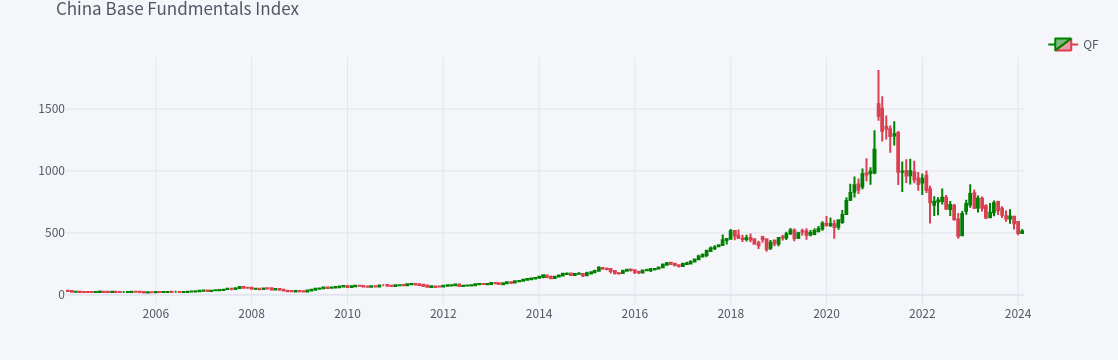

In [10]:
cf.set_config_file(offline=True, world_readable=True)
qf = cf.QuantFig(indexation, title="China Base Fundmentals Index", legend="right", name="QF")
# qf.add_volume()
# qf.add_trendline('2004-03-01','2024-01-01',on='close',textangle=0)
qf.iplot(up_color='green',down_color='red')

In [11]:
cnn = indexation
# 价格动量
cnn['6m_MA'] = cnn[CLOSE].rolling(window=6).mean()
cnn.dropna(how='any', inplace=True)
cnn['Momentum'] = cnn[CLOSE] / cnn['6m_MA']
print(cnn)

                              open     high      low    close       volume       6m_MA  Momentum
date                                                                                            
2004-08-01 00:00:00+08:00   22.710   23.156   20.318   22.113   2098310362   24.464000  0.903900
2004-09-01 00:00:00+08:00   22.124   23.825   21.078   22.059   2127620674   23.140333  0.953271
2004-10-01 00:00:00+08:00   22.589   25.767   21.782   22.703   2385615656   22.893333  0.991686
2004-11-01 00:00:00+08:00   22.888   26.831   22.517   25.758   4098080314   23.056833  1.117153
2004-12-01 00:00:00+08:00   25.577   27.187   22.589   23.560   3249070816   23.102167  1.019818
...                            ...      ...      ...      ...          ...         ...       ...
2023-10-01 00:00:00+08:00  634.464  680.811  589.197  614.975  13218242329  661.629167  0.929486
2023-11-01 00:00:00+08:00  615.705  689.777  573.888  632.340  12248677396  662.978667  0.953786
2023-12-01 00:00:00+08:00  630

In [12]:
# 价格强度
cnn['12m_High'] = cnn[CLOSE].rolling(window=12).max()
cnn['12m_Low'] = cnn[CLOSE].rolling(window=12).min()
cnn.dropna(how='any', inplace=True)
new_highs = (cnn[CLOSE] == cnn['12m_High']).sum()
new_lows = (cnn[CLOSE] == cnn['12m_Low']).sum()
cnn['Strength'] = new_highs / (new_highs + new_lows)

print(cnn)

                              open     high      low    close       volume       6m_MA  Momentum  12m_High  12m_Low  Strength
date                                                                                                                         
2005-07-01 00:00:00+08:00   23.283   25.614   22.564   24.332   2372992161   23.101000  1.053288    25.758   22.059  0.774194
2005-08-01 00:00:00+08:00   24.503   25.995   22.405   23.740   3152257386   22.980667  1.033042    25.758   22.059  0.774194
2005-09-01 00:00:00+08:00   23.931   25.154   20.010   22.716   2767475368   23.070833  0.984620    25.758   22.175  0.774194
2005-10-01 00:00:00+08:00   22.700   23.079   17.511   18.800   2230212074   22.506833  0.835302    25.758   18.800  0.774194
2005-11-01 00:00:00+08:00   18.952   21.370   18.341   20.600   2950354371   22.242167  0.926169    24.462   18.800  0.774194
...                            ...      ...      ...      ...          ...         ...       ...       ...      ...   

In [13]:
# 价格宽度
advances = (cnn[CLOSE].diff() > 0).sum()
declines = (cnn[CLOSE].diff() < 0).sum()
cnn['Breadth'] = advances / (advances + declines)
# 市场波动
cnn['Volatility'] = cnn[CLOSE].pct_change().rolling(window=12).std()
# 市场成交量
cnn['Volume_Change'] = cnn['volume'].pct_change()
cnn.dropna(how='any', inplace=True)
print(cnn)

                              open     high      low    close       volume       6m_MA  Momentum  12m_High  12m_Low  Strength   Breadth  Volatility  Volume_Change
date                                                                                                                                                              
2006-07-01 00:00:00+08:00   23.455   23.898   21.341   22.586  16842763191   22.832833  0.989190    23.740   18.800  0.774194  0.605381    0.087846      -0.523040
2006-08-01 00:00:00+08:00   22.473   24.454   21.503   23.092  12046097520   23.041167  1.002206    23.605   18.800  0.774194  0.605381    0.087834      -0.284791
2006-09-01 00:00:00+08:00   23.094   25.347   22.425   24.479  11722778500   23.310333  1.050135    24.479   18.800  0.774194  0.605381    0.088145      -0.026840
2006-10-01 00:00:00+08:00   25.733   27.771   24.108   26.185  45940582660   23.765000  1.101830    26.185   19.824  0.774194  0.605381    0.068058       2.918916
2006-11-01 00:00:00+08

In [14]:
# 标准化指标
factors = ['Momentum', 'Strength', 'Breadth', 'Volatility', 'Volume_Change']
indexation_normalized = (cnn[factors] - cnn[factors].min()) / (cnn[factors].max() - cnn[factors].min())

# 计算恐慌贪婪指数
cnn['Fear_Greed_Index'] = indexation_normalized.mean(axis=1) * 100

# 查看恐慌贪婪指数
cnn.dropna(how='any', inplace=True)
print(cnn)

                              open     high      low    close       volume       6m_MA  Momentum  12m_High  12m_Low  Strength   Breadth  Volatility  Volume_Change  Fear_Greed_Index
date                                                                                                                                                                                
2006-07-01 00:00:00+08:00   23.455   23.898   21.341   22.586  16842763191   22.832833  0.989190    23.740   18.800  0.774194  0.605381    0.087846      -0.523040         30.602761
2006-08-01 00:00:00+08:00   22.473   24.454   21.503   23.092  12046097520   23.041167  1.002206    23.605   18.800  0.774194  0.605381    0.087834      -0.284791         33.283273
2006-09-01 00:00:00+08:00   23.094   25.347   22.425   24.479  11722778500   23.310333  1.050135    24.479   18.800  0.774194  0.605381    0.088145      -0.026840         37.852624
2006-10-01 00:00:00+08:00   25.733   27.771   24.108   26.185  45940582660   23.765000  1.10183

/home/zhangruian/.local/lib/python3.11/site-packages/cufflinks/plotlytools.py:117: FutureWarning:

DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



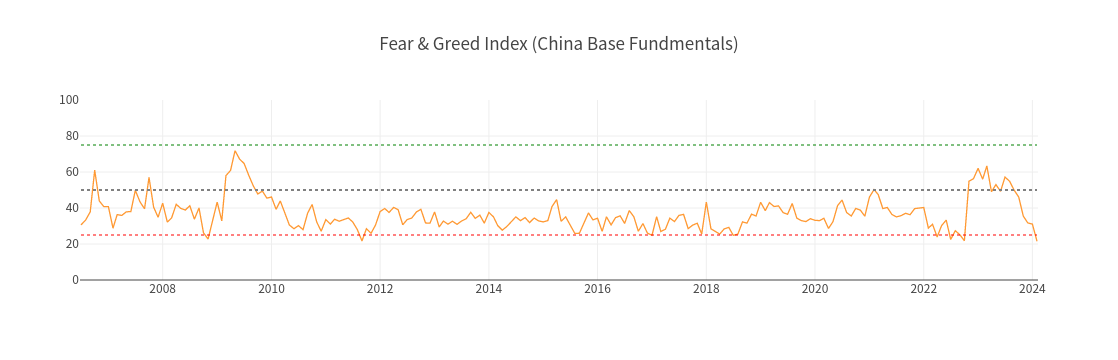

In [15]:
layout = {
    'shapes': [
        {
            'type': 'line',
            'x0': cnn.index.min(),
            'y0': 75,  # 指定线的y值
            'x1': cnn.index.max(),
            'y1': 75,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'green',
                'width': 1,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        },
        {
            'type': 'line',
            'x0': cnn.index.min(),
            'y0': 50,  # 指定线的y值
            'x1': cnn.index.max(),
            'y1': 50,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'gray',
                'width': 2,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        },
        {
            'type': 'line',
            'x0': cnn.index.min(),
            'y0': 25,  # 指定线的y值
            'x1': cnn.index.max(),
            'y1': 25,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'red',
                'width': 1,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        }
    ],
    'yaxis': {
        'range': [0, 100]  # 设置y轴的最小值和最大值
    },
    'y0': 50,  # 指定线的y值
    'title': 'Fear & Greed Index (China Base Fundmentals)'
}

cnn['Fear_Greed_Index'].iplot(kind='line', layout=layout)